- добавить комментарии к ячейкам
- оформить все

Задание из видео Карпова [Разбор тестового задания на позицию junior аналитика данных](https://www.youtube.com/watch?v=3VWDh-gdiYg)

Описание данных:  
orders - таблица с информацией о заказах;  
order_id - уникальный идентификатор заказа;  
customer_id - уникальный идентификатор клиента;  
order_date - дата, когда заказ был создан;  
order_amount - cумма заказа;  
platform - платформа, через которую был сделан заказ (например, 'mobile', 'desktop');  
category - категория товара, который был заказан (например, 'smartphones', 'laptops').

1. Построй когортый анализ: выдели клиентов, совершивших первую покупку в течение определенного месяца (когортную дату) и вычисли размер каждой когорты.  
2. Рассчитай средний доход с клиента для каждой когорты за 10 дней с момента их первой покупки.  
3. Отобрази результаты по месяцам первых покупок, категориям товаров и платформам.  

Вывод должен содержать следующие поля:
- дата когорты;
- платформа;
- категория товара;
- размер когорты;
- средний доход с клиента.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(style='whitegrid', palette='pastel')

In [3]:
customer_ids = np.array([])
ids = []
for i in range(1, 1001):
    ids.append(i)
    customer_ids = np.append(customer_ids, np.random.choice(ids, (1, i // 50 + 1)))

In [4]:
customer_ids = customer_ids.astype(int)

In [5]:
# число заказов
N = customer_ids.size

In [6]:
order_dates = pd.date_range('2023-01-01', '2024-02-01', periods=N)

In [7]:
order_amounts = 111 + np.random.exponential(1, N) * 10000

In [8]:
platforms = np.random.choice(['mobile', 'desktop', 'shop'], N, p=[0.5, 0.3, 0.2])

In [9]:
categories = np.random.choice(['smartphones', 'laptops', 'watches'], N, p=[0.5, 0.3, 0.2])

In [10]:
df = pd.DataFrame({
    'order_id': range(1, N + 1), 
    'customer_id': customer_ids, 
    'order_date': order_dates, 
    'order_amount': order_amounts, 
    'platform': platforms, 
    'category': categories
})

In [11]:
df.dtypes

order_id                 int64
customer_id              int32
order_date      datetime64[ns]
order_amount           float64
platform                object
category                object
dtype: object

In [12]:
df.order_id = df.order_id.astype('int32')

In [13]:
df.platform = df.platform.astype('category')

In [14]:
df.category = df.category.astype('category')

In [15]:
df.dtypes

order_id                 int32
customer_id              int32
order_date      datetime64[ns]
order_amount           float64
platform              category
category              category
dtype: object

In [16]:
# df.to_pickle('data.pkl')

In [16]:
# времядату превращаем в дату
df['order_day'] = df.order_date.dt.to_period('D')

In [17]:
# месяц, в котором совершена первая покупка
df['first_order_month'] = (
    df
    .groupby('customer_id')['order_date']
    .transform('min')
    .dt.to_period('M')
)

In [18]:
# сколько дней прошло с первой покупки
df['day_from_start'] = (
    df['order_day'].astype(int) 
    - df.groupby('customer_id')['order_day'].transform('min').astype(int)
)
df['day_from_start'] = df['day_from_start'].astype('int32')

In [19]:
# доход с покупателя в течение первых 10 дней
df['income_10_days'] = df[df.day_from_start < 10].groupby('customer_id').order_amount.transform(sum)

### 1
**Выдели клиентов, совершивших первую покупку в течение определенного месяца (когортную дату) и вычисли размер каждой когорты.**

In [22]:
# размер когорты каждого месяца
cohort_sizes = df.groupby('first_order_month').customer_id.nunique().reset_index()[:12]
cohort_sizes = cohort_sizes.rename(columns={'customer_id': 'cohort_size'})
cohort_sizes

,first_order_month,cohort_size
0,2023-01,226
1,2023-02,99
2,2023-03,92
3,2023-04,69
4,2023-05,71
5,2023-06,61
6,2023-07,63
7,2023-08,54
8,2023-09,44
9,2023-10,39


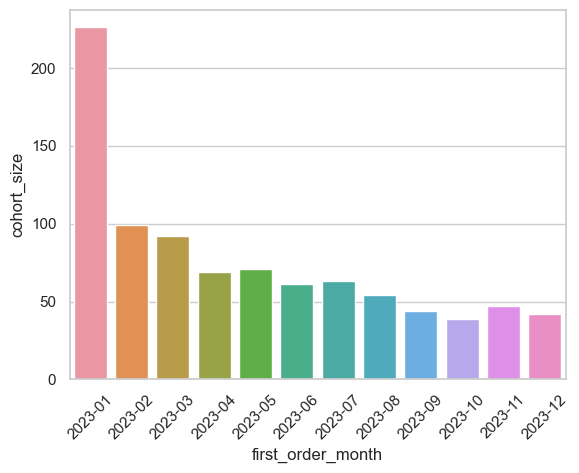

In [29]:
plt.xticks(rotation=45)
sns.barplot(data=cohort_sizes, x='first_order_month', y='cohort_size');

### 2
**Рассчитай средний доход с клиента для каждой когорты за 10 дней с момента их первой покупки.**

In [25]:
incomes_10_days = (
    df
    .groupby(['first_order_month', 'customer_id'])
    .income_10_days
    .min()
    .reset_index()
)
incomes_10_days.sample(5)

,first_order_month,customer_id,income_10_days
846,2023-11,864,12221.274414
751,2023-09,759,19796.574203
308,2023-02,327,629.371449
750,2023-09,758,18013.677131
494,2023-05,469,262.350607


In [26]:
mean_user_incomes_10_days = (
    incomes_10_days
    .groupby('first_order_month')
    .agg(
        cohort_size=('customer_id', 'nunique'), 
        mean_user_income_10_days=('income_10_days', 'mean')
    )
    .astype(int)
    .reset_index()
    [:12]
)
mean_user_incomes_10_days

,first_order_month,cohort_size,mean_user_income_10_days
0,2023-01,226,26640
1,2023-02,99,18582
2,2023-03,92,17152
3,2023-04,69,13839
4,2023-05,71,14351
5,2023-06,61,14998
6,2023-07,63,13127
7,2023-08,54,11353
8,2023-09,44,10390
9,2023-10,39,13930


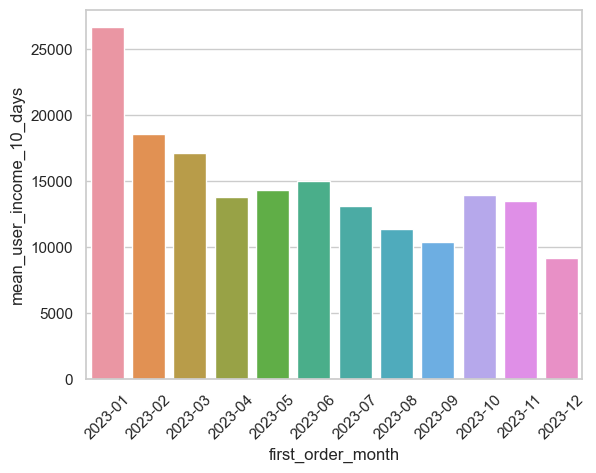

In [33]:
plt.xticks(rotation=45)
sns.barplot(data=mean_user_incomes_10_days, x='first_order_month', y='mean_user_income_10_days');
# sns.lmplot(data=mean_user_incomes_10_days, x='first_order_month', y='mean_user_income_10_days');

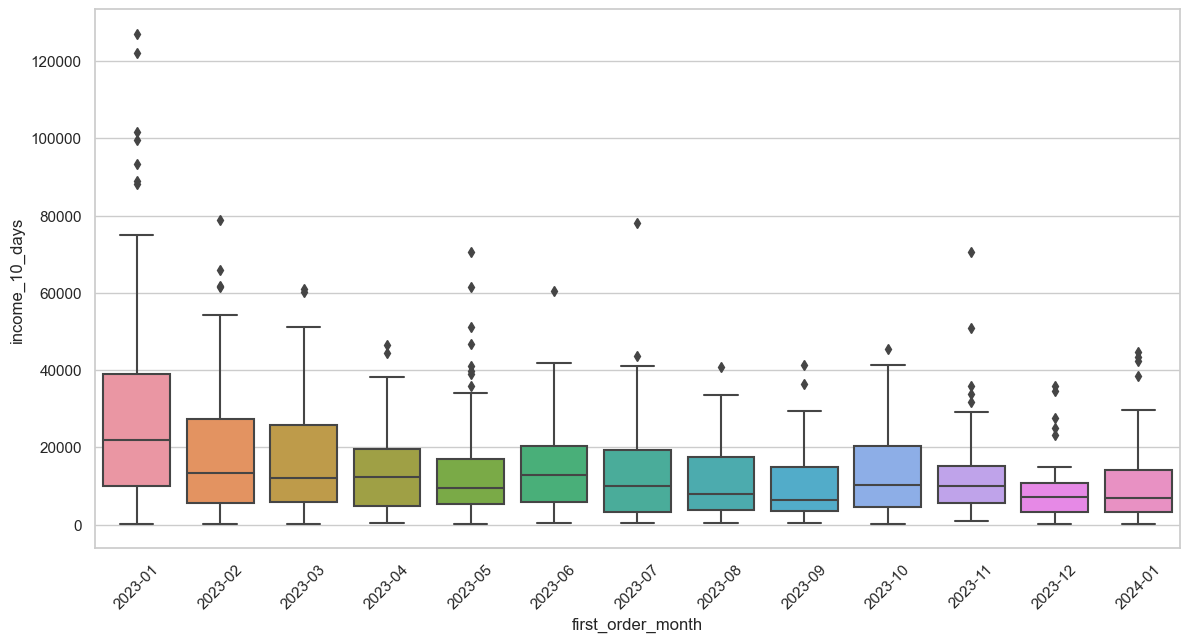

In [34]:
plt.figure(figsize=(14, 7))
plt.xticks(rotation=45)
sns.boxplot(data=incomes_10_days, y='income_10_days', x='first_order_month');

### 3
**Отобрази результаты по месяцам первых покупок, категориям товаров и платформам.**

Посчитаем поюзерное среднее по платформам

In [46]:
#  для каждого пользователя найдем сумму его заказов на каждой платформе
incomes_10_days_by_platform = (
    df[df.day_from_start < 10]
    .groupby(['customer_id', 'platform'])
    .order_amount
    .sum()
    .reset_index()
)
incomes_10_days_by_platform.columns = ['customer_id', 'platform', 'orders_sum']
incomes_10_days_by_platform.sample(5)

,customer_id,platform,orders_sum
1745,582,shop,0.000000
911,304,shop,0.000000
42,15,desktop,29788.484047
1067,356,shop,0.000000
1586,529,shop,3885.510265


In [47]:
# "словарь" с первыми месяцами для каждого пользователя
first_months = df[df.day_from_start < 10][['customer_id', 'first_order_month']].groupby('customer_id').min()
first_months.sample(5)

,first_order_month
customer_id,
441,2023-04
525,2023-05
118,2023-01
8,2023-01
826,2023-11


In [49]:
# приджойним данные по первым месяцам
incomes_10_days_by_platform_and_first_month = incomes_10_days_by_platform.join(first_months, on='customer_id')
incomes_10_days_by_platform_and_first_month.sample(5)

,customer_id,platform,orders_sum,first_order_month
868,290,mobile,7180.900030,2023-02
250,84,mobile,61779.042695,2023-01
32,11,shop,0.000000,2023-01
2523,846,desktop,0.000000,2023-11
628,210,mobile,18649.821151,2023-01


In [56]:
(
    incomes_10_days_by_platform_and_first_month
    .pivot_table('orders_sum', 'first_order_month', 'platform')
    .round()
    .astype(int)
    [:12].
    style.background_gradient()
)

platform,desktop,mobile,shop
first_order_month,,,
2023-01,8506,13525,4609
2023-02,7553,7794,3235
2023-03,4956,9789,2408
2023-04,3418,8520,1902
2023-05,3903,7134,3314
2023-06,4135,7661,3203
2023-07,5903,5192,2031
2023-08,2447,6888,2019
2023-09,3489,4904,1998


Если в расчете среднего дохода с клиента не надо учитывать категории товаров, в которых пользователь не сделал покупок, то поюзерные среднии будут больше:

In [57]:
(
    incomes_10_days_by_platform_and_first_month[incomes_10_days_by_platform_and_first_month.orders_sum!=0]
    .pivot_table('orders_sum', 'first_order_month', 'platform')
    .round()
    .astype(int)
    [:12].
    style.background_gradient()
)

platform,desktop,mobile,shop
first_order_month,,,
2023-01,15630,17172,10211
2023-02,15910,12860,11042
2023-03,11120,15264,9632
2023-04,9433,11998,9374
2023-05,10264,11779,10695
2023-06,11466,11982,10854
2023-07,14304,8841,9844
2023-08,7772,10940,8385
2023-09,9594,8631,10987


In [121]:
(
    df[df.day_from_start < 10]
    .pivot_table('order_amount', 'first_order_month', 'category')[:12]
    .round()
    .astype(int)
    .style.background_gradient()
)

category,laptops,smartphones,watches
first_order_month,,,
2023-01,11180,9675,10757
2023-02,11243,9561,8347
2023-03,7704,10083,13117
2023-04,11289,10548,11789
2023-05,7000,7277,9781
2023-06,10400,10779,10376
2023-07,11299,11048,16148
2023-08,10067,10620,10912
2023-09,8047,9193,10355


In [35]:
df.sample(10)

,order_id,customer_id,order_date,order_amount,platform,category,order_day,first_order_month,day_from_start,income_10_days
3258,3259,511,2023-05-03 15:37:43.903412872,248.968819,shop,watches,2023-05-03,2023-05,0,6293.425195
9371,9372,486,2023-12-19 18:46:22.393763668,3496.569252,desktop,watches,2023-12-19,2023-05,232,NaN
7646,7647,307,2023-10-15 20:13:18.098678584,14701.468006,desktop,smartphones,2023-10-15,2023-03,225,NaN
5396,5397,47,2023-07-23 03:19:43.800741516,2862.313770,mobile,laptops,2023-07-23,2023-01,200,NaN
6760,6761,594,2023-09-12 11:42:49.179579808,11985.594338,desktop,laptops,2023-09-12,2023-06,86,NaN
4184,4185,218,2023-06-07 12:16:37.965586082,4828.848678,desktop,laptops,2023-06-07,2023-02,120,NaN
3172,3173,31,2023-04-30 09:55:37.845802834,187.985353,mobile,smartphones,2023-04-30,2023-01,117,NaN
489,490,108,2023-01-19 09:48:55.374084989,8069.734042,shop,watches,2023-01-19,2023-01,10,NaN
8199,8200,130,2023-11-05 15:51:41.701682672,9745.646411,mobile,smartphones,2023-11-05,2023-01,291,NaN
3762,3763,480,2023-05-22 14:59:48.706150776,19234.472170,mobile,smartphones,2023-05-22,2023-04,34,NaN


In [207]:
df.size

229950